In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta

import sys
sys.path.append( '../../src/' )

from ml.preprocessing import *

# Data Cleaning

In [2]:
df = pd.read_csv( '../../datasets/Sensado_GYM_Completo.csv', encoding = 'ISO-8859-1', parse_dates = [ 'Fecha' ] )
df.columns = [ 'date', 'pre', 'alt', 'hum', 'tem', 'occ' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10129 non-null  datetime64[ns]
 1   pre     10129 non-null  float64       
 2   alt     10129 non-null  float64       
 3   hum     10125 non-null  float64       
 4   tem     10129 non-null  float64       
 5   occ     10129 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 474.9+ KB


## Filling null values

In [3]:
len( df ) - df.count()

date    0
pre     0
alt     0
hum     4
tem     0
occ     0
dtype: int64

In [4]:
df[ 'hum' ].fillna( method ='ffill', inplace = True )
len( df ) - df.count()

date    0
pre     0
alt     0
hum     0
tem     0
occ     0
dtype: int64

In [5]:
# date format mm-dd-yyyy

temp = df[ ( df.date >= '2019-01-01' ) & ( df.date <= '2019-02' ) ][ 'date' ] + timedelta( days = 264 )
df.loc[ temp.index, 'date' ] = temp

# Preparing the Datasets

In [6]:
import enum

class DF( enum.Enum ):
    _10SEC = 1
    _REDUCED = 2
    _MIN = 3

AGG = [ 'mean', 'std', pd.DataFrame.kurt ]
# AGG = [ 'mean' ]

dfs = { DF._10SEC: None, DF._REDUCED: None } # holds the dataframes
grids = { 
    'svc': { DF._10SEC: None, DF._REDUCED: None, DF._MIN: None },
    'knn': { DF._10SEC: None, DF._REDUCED: None, DF._MIN: None },
    'dt': { DF._10SEC: None, DF._REDUCED: None, DF._MIN: None } }

# holds the search grids 

## 10 sec. avg. with extra features (std, kurtosis)

In [10]:
def agg_date( col ):
    return col.iloc[ 0 ] # left labeling

def agg_occupancy( col ): 
    return col.mode()[ 0 ]

def groupby_10( g, agg ):
    return g.groupby( np.arange( len( g ) ) // 10 ).agg( { 
        'date': agg_date, 
        'occ': agg_occupancy,
        'pre': agg, 
        'alt': agg, 
        'hum': agg, 
        'tem': agg } )

def rename_col( name ):
    return name[ 0 ] + '_' + name[ 1 ]

temp =  ( df.groupby( df.date.dt.floor( 'D' ) )
    .apply( groupby_10, AGG )
    .reset_index( drop = True ) )

temp.columns = [ rename_col( c ) for c in temp.columns ]
temp = ( temp
    .rename( columns = { 'date_agg_date': 'date', 'occ_agg_occupancy': 'occ' } )
    .sort_values( by = 'date' )
    .reset_index( drop = True ) )

dfs[ DF._10SEC ] = temp.dropna( how = 'any' )
dfs[ DF._10SEC ]

,date,occ,pre_mean,pre_std,pre_kurt,alt_mean,alt_std,alt_kurt,hum_mean,hum_std,hum_kurt,tem_mean,tem_std,tem_kurt
0,2019-09-18 19:04:00,M,95004.394,1.471139,-0.388939,540.046,0.129546,-0.423667,58.536,0.114717,-1.599263,27.176,0.005164,-2.276786
1,2019-09-18 19:04:00,M,95005.281,2.629582,3.415204,539.989,0.244652,1.309810,59.008,0.684751,-1.577536,27.144,0.047656,-0.987756
2,2019-09-18 19:04:00,M,95005.590,1.249871,-0.554256,539.935,0.107316,0.245743,60.226,0.580310,-1.948870,27.077,0.018288,-1.984179
3,2019-09-18 19:04:00,M,95007.742,1.271096,-0.322791,539.752,0.111734,-0.303842,60.301,0.352750,-0.689239,27.113,0.006749,-0.282995
4,2019-09-18 19:04:00,M,95005.783,1.822569,-0.831063,539.923,0.159377,-0.831768,59.250,0.323075,-1.621835,27.061,0.017288,-0.249108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,2019-10-02 20:48:00,L,95188.350,1.785858,-0.155625,523.924,0.155578,-0.154378,58.925,0.180939,-1.703576,27.201,0.005676,1.498216
1010,2019-10-02 20:48:00,L,95200.459,1.282501,-0.947767,522.864,0.110775,-0.970870,59.148,0.017512,-0.341277,27.263,0.004830,-1.224490
1011,2019-10-02 20:48:00,L,95199.183,1.158352,0.611637,522.974,0.101237,0.564391,59.220,0.046188,0.673096,27.270,0.000000,0.000000
1012,2019-10-02 20:48:00,L,95198.701,1.788180,-0.067923,523.018,0.155977,-0.124447,58.951,0.093743,-0.870702,27.250,0.008165,-1.392857


## 10 sec. avg with reduced features (temp, hum, and pre )

In [14]:
temp =  ( df.groupby( df.date.dt.floor( 'D' ) )
    .apply( groupby_10, AGG )
    .reset_index( drop = True ) )

temp.columns = [ rename_col( c ) for c in temp.columns ]
temp = ( temp
    .rename( columns = { 'date_agg_date': 'date', 'occ_agg_occupancy': 'occ' } )
    .reset_index( drop = True )
    .drop( columns = [ 'tem_std', 'tem_kurt', 'hum_std', 'hum_kurt', 'pre_std', 'pre_kurt', 'alt_std', 'alt_kurt', 'alt_mean' ] ) )

dfs[ DF._MIN ] = temp.dropna( how = 'any' )
dfs[ DF._MIN ]

,date,occ,pre_mean,hum_mean,tem_mean
0,2019-09-18 19:04:00,M,95004.394000,58.536000,27.176000
1,2019-09-18 19:04:00,M,95005.281000,59.008000,27.144000
2,2019-09-18 19:04:00,M,95005.590000,60.226000,27.077000
3,2019-09-18 19:04:00,M,95007.742000,60.301000,27.113000
4,2019-09-18 19:04:00,M,95005.783000,59.250000,27.061000
...,...,...,...,...,...
1010,2019-10-02 20:48:00,L,95199.183000,59.220000,27.270000
1011,2019-10-02 20:48:00,L,95198.701000,58.951000,27.250000
1012,2019-10-02 20:48:00,L,95189.847000,59.104000,27.270000
1013,2019-10-02 20:48:00,L,95188.350000,58.925000,27.201000


# Features Selection

In [24]:
from ml.feature_selection import *
from ml.generation import *

## Recursive Feature Elimination 

In [27]:
x_train, x_test, y_train, y_test = split_data( dfs[ DF._10SEC ].set_index( 'date' ), test_size = 0.20 )
x_train, x_test = standardize( x_train, x_test )
selected_rfe = select_k_rfe( x_train, y_train, dfs[ DF._10SEC ].columns[ 2: ], 1 )
selected_rfe

,rank,selected
pre_mean,1,1
tem_mean,2,0
hum_mean,3,0
tem_kurt,4,0
tem_std,5,0
hum_kurt,6,0
hum_std,7,0
alt_mean,8,0
alt_kurt,9,0
alt_std,10,0


## 3.2 Selecting K-best

In [28]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions( precision = 2 )

selected_kbest = select_k_best( x_train, y_train, dfs[ DF._10SEC ].columns[ 2: ], 3 )
selected_kbest

,score,p-value
tem_mean,69.13,0.00
hum_mean,54.03,0.00
alt_mean,48.52,0.00
pre_mean,48.48,0.00
hum_std,6.78,0.00
tem_std,6.30,0.00
tem_kurt,3.89,0.02
alt_std,2.86,0.06
pre_std,2.75,0.06
hum_kurt,2.05,0.13


## 3.3 Feature Correlation

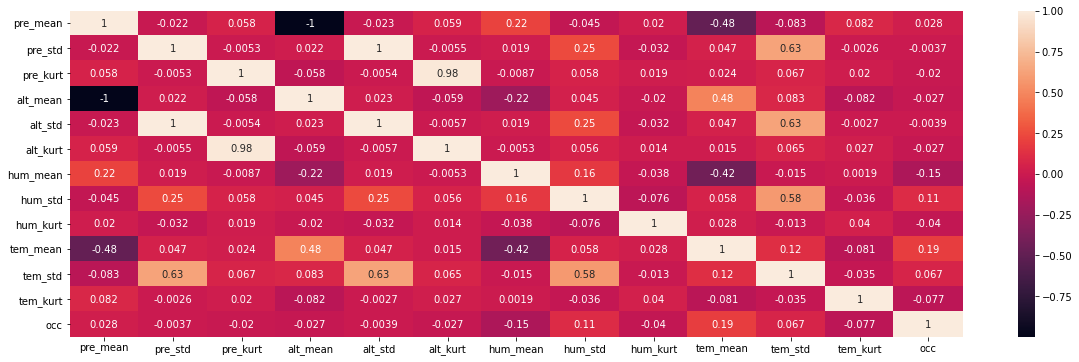

In [41]:
occ_int = dfs[ DF._10SEC ][ 'occ' ].replace( { 'L':0, 'M':2, 'H':1 } )
temp = pd.concat( [ dfs[ DF._10SEC ], occ_int ], axis = 1 ).dropna( thresh = 2 )

plt.subplots( 1, 1, figsize = ( 20, 6 ) )
sns.heatmap( temp.corr(), annot = True )

Pressure and altitude presents and strong correlation, suggesting we should remove one of them. 

## Generating reduced dataset

In [49]:
dfs[ DF._REDUCED ] = dfs[ DF._10SEC ].drop( columns = [ 'alt_std', 'pre_std', 'hum_kurt', 'alt_kurt', 'pre_kurt' ] )

# Standarization

Pressure have a different magnitud of values than temperature, humidity. Then it is necesary to standarize the dataset before applying any algorithm to prevent pressure from dominating the other features

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_TRAIN = 0
X_TEST = 1
Y_TRAIN = 2
Y_TEST = 3

def standarize( df ):
    x_train, x_test, y_train, y_test = train_test_split( 
        df.drop( [ 'occ', 'date' ], axis = 1 ), 
        df.occ, 
        test_size = .20, 
        random_state = 0 )
    
    scaler = StandardScaler()
    scaler.fit( x_train )

    x_train = scaler.transform( x_train )
    x_test = scaler.transform( x_test )
    
    return x_train, x_test, y_train, y_test

for k, d in dfs.items() : 
    x_train, x_test, y_train, y_test = standarize( d )
    dfs[ k ] = [ x_train, x_test, y_train, y_test ]

# Balancing Classes

In [59]:
from imblearn.over_sampling import ADASYN
from collections import Counter

neighborgs = { DF._10SEC: 1, DF._REDUCED: 1, DF._MIN: 27 }
for k, d in dfs.items() :   
    oversampler = ADASYN( 
        sampling_strategy = 'not majority', 
        n_neighbors = neighborgs[ k ], 
        random_state = 42 )
    
    x_train, y_train = oversampler.fit_resample( d[ X_TRAIN ], d[ Y_TRAIN ] )
    
    print( 'Before:', k, Counter( d[ Y_TRAIN ] ) )
    d[ X_TRAIN ] = x_train
    d[ Y_TRAIN ] = y_train
    print( 'After:', k, Counter( y_train ) )
    print()

Before: DF._10SEC Counter({'M': 433, 'L': 197, 'H': 180})
After: DF._10SEC Counter({'H': 435, 'M': 433, 'L': 431})

Before: DF._REDUCED Counter({'M': 433, 'L': 197, 'H': 180})
After: DF._REDUCED Counter({'L': 433, 'M': 433, 'H': 432})

Before: DF._MIN Counter({'M': 436, 'L': 194, 'H': 182})
After: DF._MIN Counter({'H': 438, 'M': 436, 'L': 436})



# Classification

In [61]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA



def grid_search( estimator, params ):
    scoring = 'accuracy'
    cv_method = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 2, random_state = 0 )
    
    return GridSearchCV( 
        estimator = estimator,
        param_grid = params,
        cv = cv_method,
        verbose = False,
        scoring = scoring,
        return_train_score = True )


def train_and_test( estimator, params, x_train, y_train, 
                   x_test, y_test, plot_cmatrix = False ):
    
    grid = grid_search( estimator, params )
    
    # Training and evaluation

    grid.fit( x_train, y_train );
    print( 'Best params: ', grid.best_params_ )
    print( 'Training Accuracy', grid.best_score_ )

    y_pred = grid.best_estimator_.predict( x_test )
    print( 'Test Accuracy: ', accuracy_score( y_test, y_pred ) )
    
    if( plot_cmatrix ) :
        fig, ax = plt.subplots( 1, 1 )
        g = sns.heatmap( confusion_matrix( y_test, y_pred ), annot = True, cmap = "YlGnBu" )
        g.set_title( 'Test Confussion Matrix' )
    
    return grid
    
def add_pca_estimator( estimator ):
    return Pipeline( [ ( 'reduce_dim', PCA( .95 ) ),  ( 'clf', estimator ) ] )
    
def prefix_params( d_list, prefix ):
    result = []
    for d in d_list: 
        temp = {}
        for key in d.keys():
            temp[ prefix + '__' + key ] = d[ key ]
        result.append( temp )
    return result

## SVM

In [63]:
%%time
params_svc = [ { 
    'C': [ 1, 10, 100 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 1, 10 ]
} ]


print( '-----------------------------------' )
print( 'Different number of features' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( 
                svm.SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()

print( '-----------------------------------' )
print( 'With PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'svc' ][ k ] = train_and_test( 
                add_pca_estimator( svm.SVC() ), 
                prefix_params( params_svc, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()


-----------------------------------
Different number of features
-----------------------------------
Dataset  DF._10SEC
Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9692128801431126
Test Accuracy:  0.9556650246305419

Dataset  DF._REDUCED
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9953726893261775
Test Accuracy:  0.9950738916256158

Dataset  DF._MIN
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9992366412213741
Test Accuracy:  0.9950738916256158

-----------------------------------
With PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Training Accuracy 0.913020274299344
Test Accuracy:  0.8177339901477833

Dataset  DF._REDUCED
Best params:  {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Training Accuracy 0.9356708407871199
Test Accuracy:  0.8768472906403941

Dataset  DF._MIN
Best params:  {'clf__C': 1, 'clf__gamm

## KNN

In [64]:
%%time
params_knn = [ { 
    'n_neighbors': [ 1, 3, 5, 7 ], 
    'p': [ 2 ], # mikowsky distance
    'algorithm': [ 'ball_tree', 'kd_tree' ]
} ]

print( '-----------------------------------' )
print( 'Different number of features' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( KNeighborsClassifier(), params_knn, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )
    print()

print( '-----------------------------------' )
print( 'With PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'knn' ][ k ] = train_and_test( 
                add_pca_estimator( KNeighborsClassifier() ), 
                prefix_params( params_knn, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()

-----------------------------------
Different number of features
-----------------------------------
Dataset  DF._10SEC
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9842158616577222
Test Accuracy:  0.9605911330049262

Dataset  DF._REDUCED
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.995381633870006
Test Accuracy:  0.9901477832512315

Dataset  DF._MIN
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9984732824427482
Test Accuracy:  0.9950738916256158

-----------------------------------
With PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 1, 'clf__p': 2}
Training Accuracy 0.8876177698270723
Test Accuracy:  0.7832512315270936

Dataset  DF._REDUCED
Best params:  {'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 1, 'clf__p': 2}
Training Accuracy 0.9329695885509841
Test Accuracy:  0.8

## Decision Trees

In [65]:
%%time
params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 4, 6, 8, 10, 12 ]
} ]

print( '-----------------------------------' )
print( 'Different number of features' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( DecisionTreeClassifier(), params_dt, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )
    print()
    
print( '-----------------------------------' )
print( 'With PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'dt' ][ k ] = train_and_test( 
        add_pca_estimator( DecisionTreeClassifier() ), 
        prefix_params( params_dt, 'clf' ), 
        df[ X_TRAIN ], df[ Y_TRAIN ], 
        df[ X_TEST ], df[ Y_TEST ] )
    print()

-----------------------------------
Different number of features
-----------------------------------
Dataset  DF._10SEC
Best params:  {'criterion': 'gini', 'max_depth': 4}
Training Accuracy 0.9984615384615385
Test Accuracy:  1.0

Dataset  DF._REDUCED
Best params:  {'criterion': 'entropy', 'max_depth': 12}
Training Accuracy 0.9930769230769231
Test Accuracy:  0.9950738916256158

Dataset  DF._MIN
Best params:  {'criterion': 'entropy', 'max_depth': 6}
Training Accuracy 0.998091603053435
Test Accuracy:  0.9950738916256158

-----------------------------------
With PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__criterion': 'entropy', 'clf__max_depth': 12}
Training Accuracy 0.8953160405485987
Test Accuracy:  0.8423645320197044

Dataset  DF._REDUCED
Best params:  {'clf__criterion': 'entropy', 'clf__max_depth': 12}
Training Accuracy 0.9021884317233153
Test Accuracy:  0.8620689655172413

Dataset  DF._MIN
Best params:  {'clf__criterion': 'entropy', 'clf__m

Con los datasets sin PCA, SVM y DT no mostraron diferencia en el accuracy entre el dataset con features extra y el dataset reducido. Por su parte KNN si hubo un incremento utilizando el dataset con features reducidos. Para el escenario donde se aplicó PCA antes de realizar la clasificación, nuevamente SVM no se mostró afectado, sin embargo DT y KNN si mostraron una diferencia positiva en el accuracy usando el dataset con features reducidos. El peor caso fue con KNN, donde se obtuvo una diferencia de 5 puntos porcentuales entre el dataset reducido (0.99) y el el dataset extendido (0.95). En general concluimos que el dataset extendido presenta signos de overfitting ya que en general los features agregados no tuvieron impacto o impactaron negativamente en el performance. 

# Evaluation

In [66]:
from ml.evaluation import *

## Learning Curves

In [67]:
temp = [ item for item in dfs.items() if item[ 0 ] ]

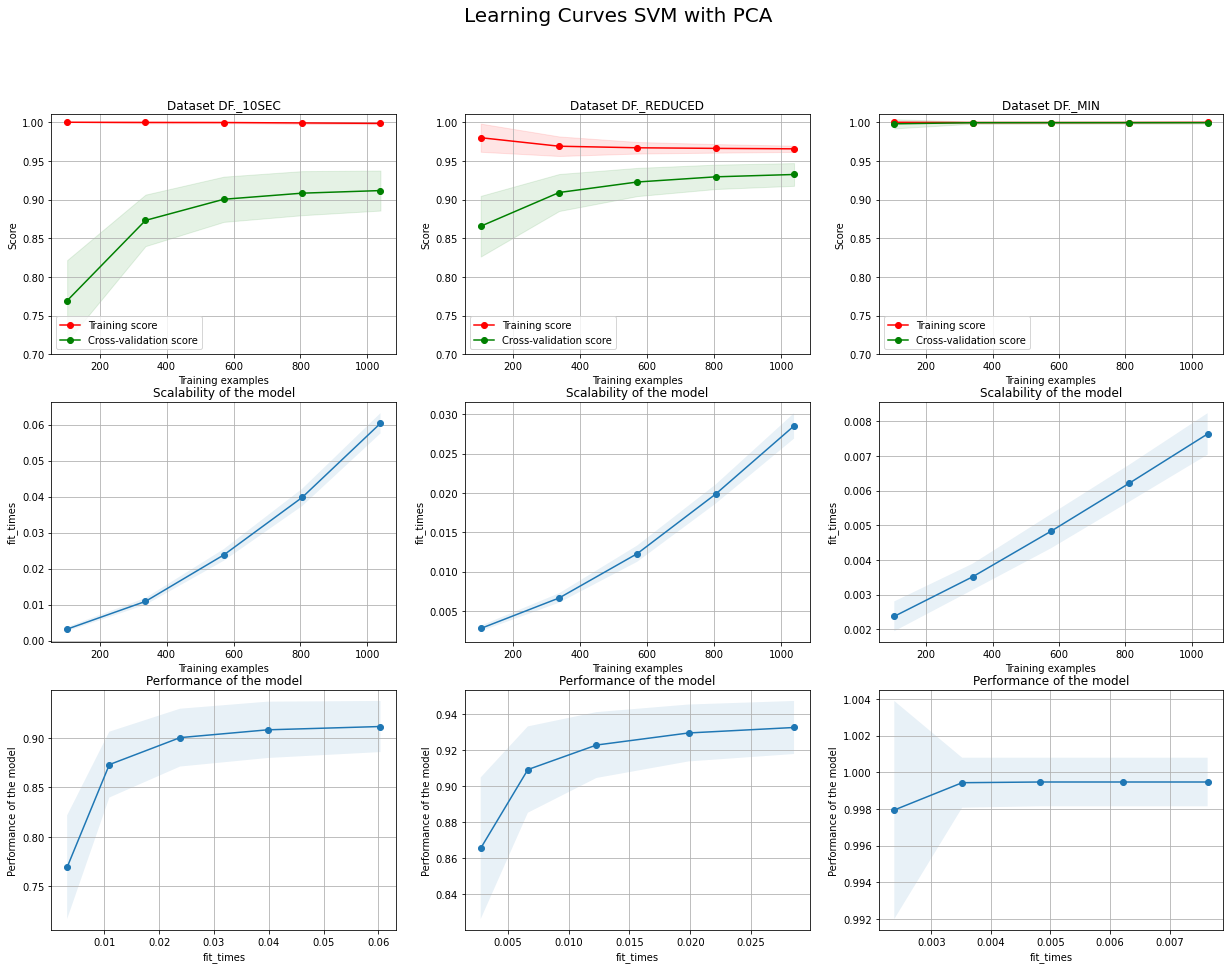

In [68]:
plot_learning_curves( temp, grids[ 'svc' ], 'SVM' )

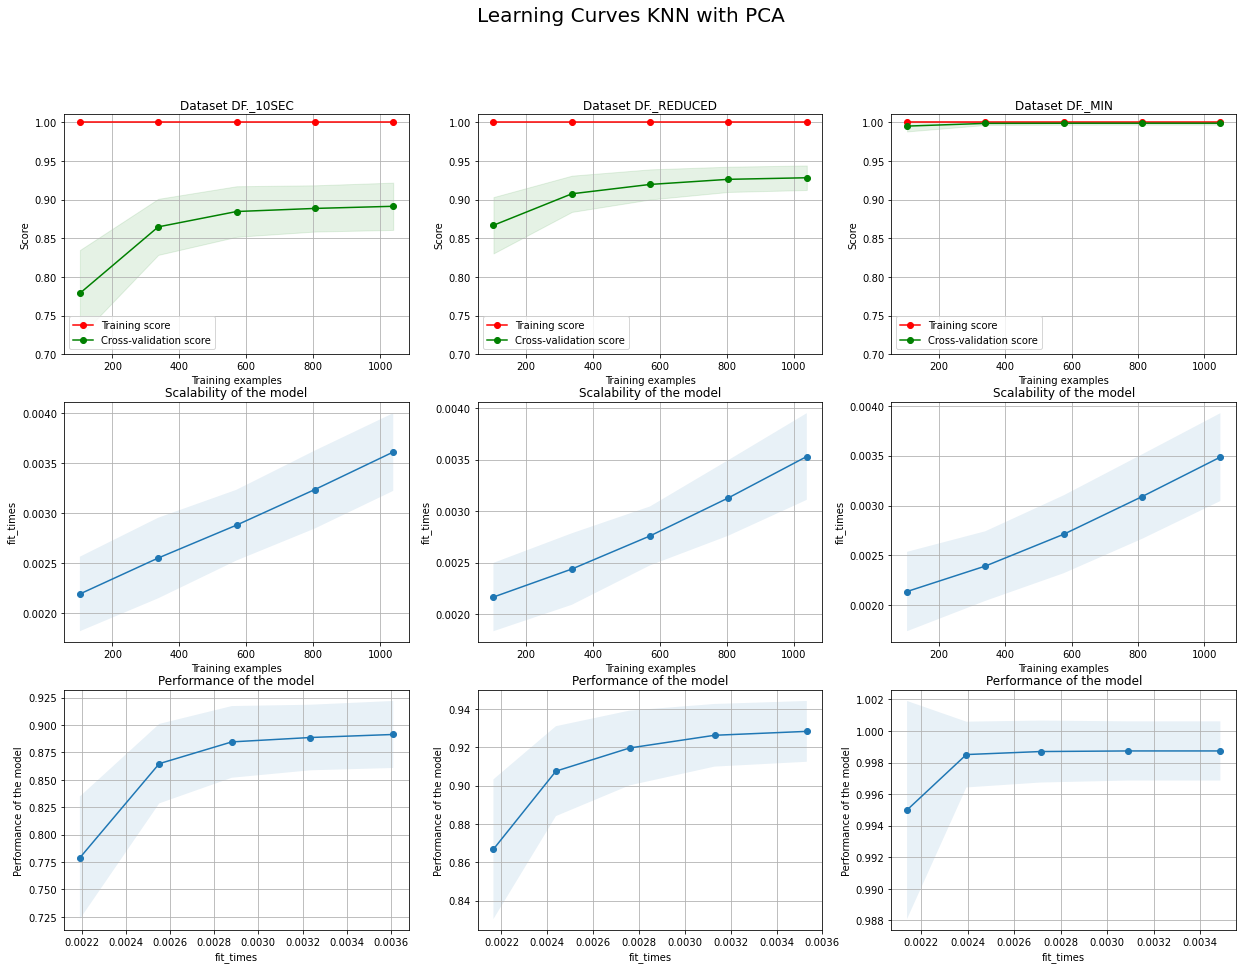

In [69]:
plot_learning_curves( temp, grids[ 'knn' ], 'KNN' )

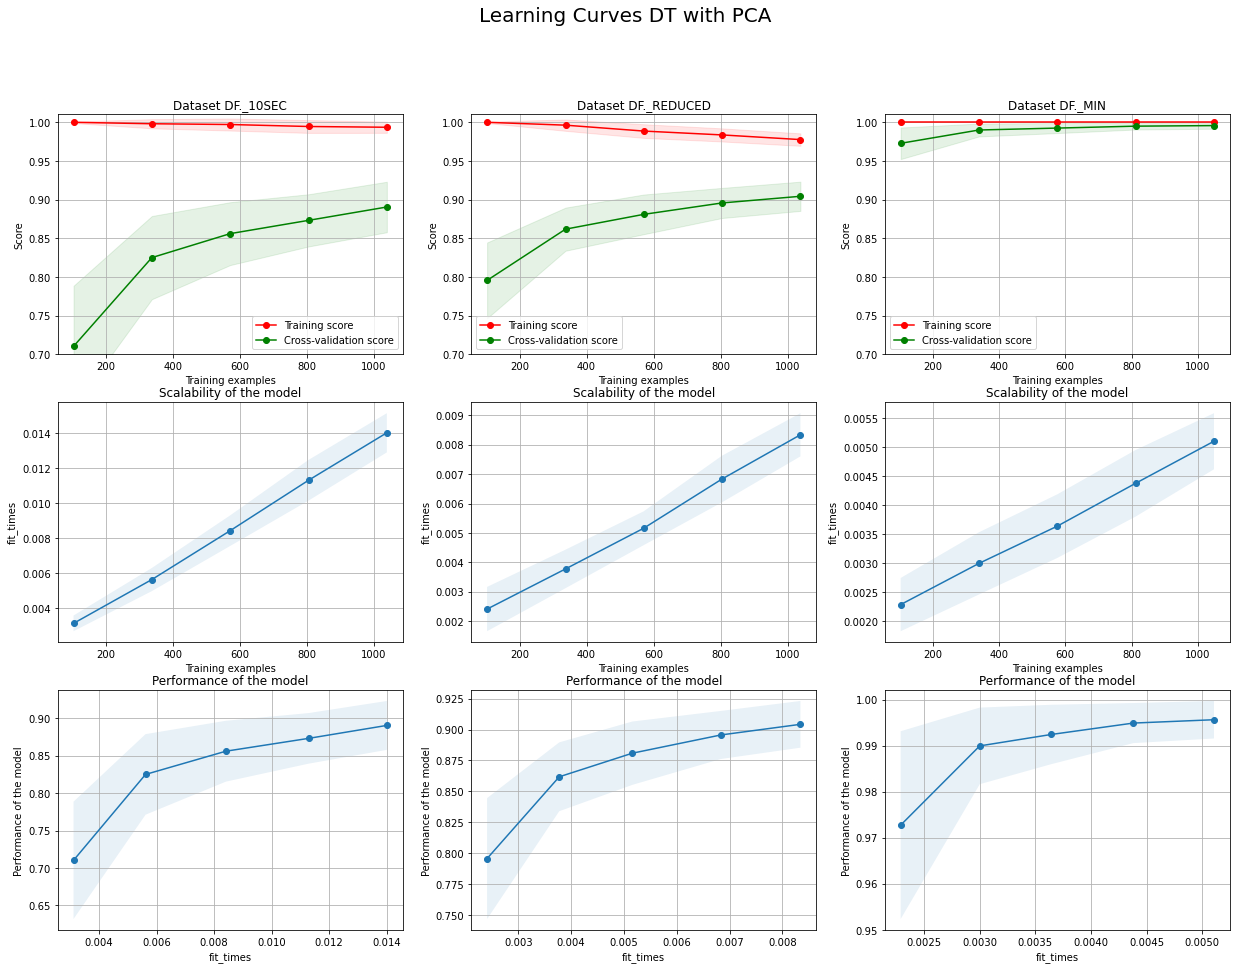

In [70]:
plot_learning_curves( temp, grids[ 'dt' ], 'DT' )